In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import SimpleITK as sitk
from util import read_sitk, plot_ct, xyz2irc
import os 
from tqdm import  tqdm

In [33]:
SPACING = [1.0, 1.0, 1.0]   # resampling 1mmx1mmx1mm

### Create Extend box (drop background)

In [34]:
def create_extendbox(img_mask, old_spacing, new_spacing=SPACING):
    m1 = img_mask == 3
    m2 = img_mask == 4

    Mask = m1 + m2
    xx, yy, zz = np.where(Mask)

    newshape = np.round(np.array(Mask.shape)*old_spacing/new_spacing).astype('int') 
    box = np.array([[np.min(xx),np.max(xx)],[np.min(yy),np.max(yy)],[np.min(zz),np.max(zz)]])
    # print(np.array(old_spacing)/np.array(new_spacing))
    # print(box)
    box = box * (np.array(old_spacing)/np.array(new_spacing)).reshape((-1, 1))
    # box = box*np.array(old_spacing)/np.array(new_spacing)
    box = np.floor(box).astype('int')
    margin = 5
    extendbox = np.vstack([np.max([[0,0,0],box[:,0]-margin],0),np.min([newshape,box[:,1]+2*margin],axis=0).T]).T

    return extendbox


### Resampling

In [35]:
from scipy import ndimage

In [36]:
def rescale_spacing(image, old_spacing, new_spacing):
    # Tính toán tỷ lệ thay đổi spacing
    scale_factor = np.array(old_spacing) / np.array(new_spacing)

    # Tính toán kích thước mới của ảnh CT
    new_shape = np.round(image.shape * scale_factor)
    new_shape = new_shape.astype(int)

    # Thay đổi kích thước ảnh CT bằng phương pháp nội suy
    resized_image = ndimage.zoom(image, scale_factor, mode='nearest')

    return resized_image


# main function
def resampling(img, old_spacing, new_spacing=SPACING):

    resized_img = rescale_spacing(img, old_spacing, new_spacing)

    return resized_img

### Normalize

In [37]:
def normalize(img):
    # clip image
    new_img = np.copy(img)
    new_img = np.clip(-1100, 200, new_img)

    # normalization min-max normalization
    minn = new_img.min()
    maxx = new_img.max()
    # max_min = maxx - minn

    return (new_img - minn) / (maxx - minn)

### Pipeline processing

In [38]:
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def pipe_line(subset, save_path="../../luna16/full_processing"):
    luna_paths = glob.glob(f"../../luna16/LUNA16/subset{subset}/*.mhd")
    annotation = pd.read_csv("../../luna16/annotations.csv")

    for path in tqdm(luna_paths):
        # check folder exists
        if not os.path.exists(save_path + f"/subset{subset}"):
            os.makedirs(save_path + f"/subset{subset}")
        if not os.path.exists(save_path + f"/subset{subset}-gt"):
            os.makedirs(save_path + f"/subset{subset}-gt")        

        uid = path.split("\\")[-1][:-4]
        mask_path = glob.glob(f"../../luna16/seg-lungs-LUNA16/{uid}.mhd")[0]
        img_mask, _, _, _ = read_sitk(mask_path)

        img, origin,  spacing, direction = read_sitk(path)

        # check and flip 
        simple_direction = np.array((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
        direction = np.round(np.array(direction))
        if not np.array_equal(simple_direction, direction):
            img_mask = img_mask[:, ::-1, ::-1]
            img = img[:, ::-1, ::-1]

        # create extendbox
        extendbox = create_extendbox(img_mask, spacing)
        
        # caculation center mask in extendbox 
        this_annos = annotation[annotation['seriesuid'] == uid].drop(columns='seriesuid').to_numpy()
        label = []
        if len(this_annos) > 0:
            for c in this_annos:
                pos = worldToVoxelCoord(c[:3][::-1],origin=origin,spacing=spacing)
                if not np.array_equal(simple_direction, direction):
                    pos[1:] = img_mask.shape[1:3]-pos[1:]
                label.append(np.concatenate([pos,[c[3]/spacing[1]]]))
        
        if len(label) == 0:
            label1 = np.array([0, 0, 0, 0])
        else:
            label1 = np.copy(label).T
            label1[:3] = label1[:3]*((spacing/SPACING).reshape((-1, 1)))
            label1[3] = label1[3]*spacing[1]/SPACING[1]
            label1[:3] = label1[:3] - np.expand_dims(extendbox[:,0],1)
            label1 = label1.T
        
        # break

        ## full preprocessing
        img_normalize = normalize(img)
        img_resampling = resampling(img_normalize, spacing)
        img_clean = img_resampling[extendbox[0,0]:extendbox[0,1],
                                    extendbox[1,0]:extendbox[1,1],
                                    extendbox[2,0]:extendbox[2,1]]

        # print(img_clean.shape)
        # print(extendbox)
        # print(origin)
        # print(label1)

        ## save
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_clean.npy"), img_clean)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_extendbox.npy"), extendbox)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_origin.npy"), origin)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_label.npy"), label1)
   
        
        
pipe_line(1)

  0%|          | 0/2 [00:20<?, ?it/s]

(297, 246, 295)
[[ 54 351]
 [ 62 308]
 [ 16 311]]
[-400.3    -351.6875 -159.6875]
[[202.3493484  133.2401766   39.7370728    5.19404575]
 [221.2703158  159.368328   207.26284973   4.38757673]]


### Test

In [39]:
from util import read_sitk, plot_ct

test_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886"

In [40]:
## Spacing test
luna_path = glob.glob(f"../../luna16/LUNA16/subset1/{test_uid}*.mhd")[0]

img, _, spacing, _ = read_sitk(luna_path)
new_img = resampling(img, spacing)

print("old: ", img.shape, spacing)
print("new: ", new_img.shape)

old:  (123, 512, 512) [2.5        0.82031202 0.82031202]
new:  (308, 420, 420)


In [41]:
## extendbox
seg_path = glob.glob(f"../../luna16/seg-lungs-LUNA16/{test_uid}.mhd")[0]

seg_img, _, spacing, _ = read_sitk(seg_path)

extendbox_c = extendbox(seg_img, spacing)

NameError: name 'extendbox' is not defined

In [ ]:
# normalize
new_img = normalize(new_img)
new_img = new_img[extendbox_c[0,0]:extendbox_c[0,1],
                    extendbox_c[1,0]:extendbox_c[1,1],
                    extendbox_c[2,0]:extendbox_c[2,1]]
new_img.shape

(252, 231, 331)

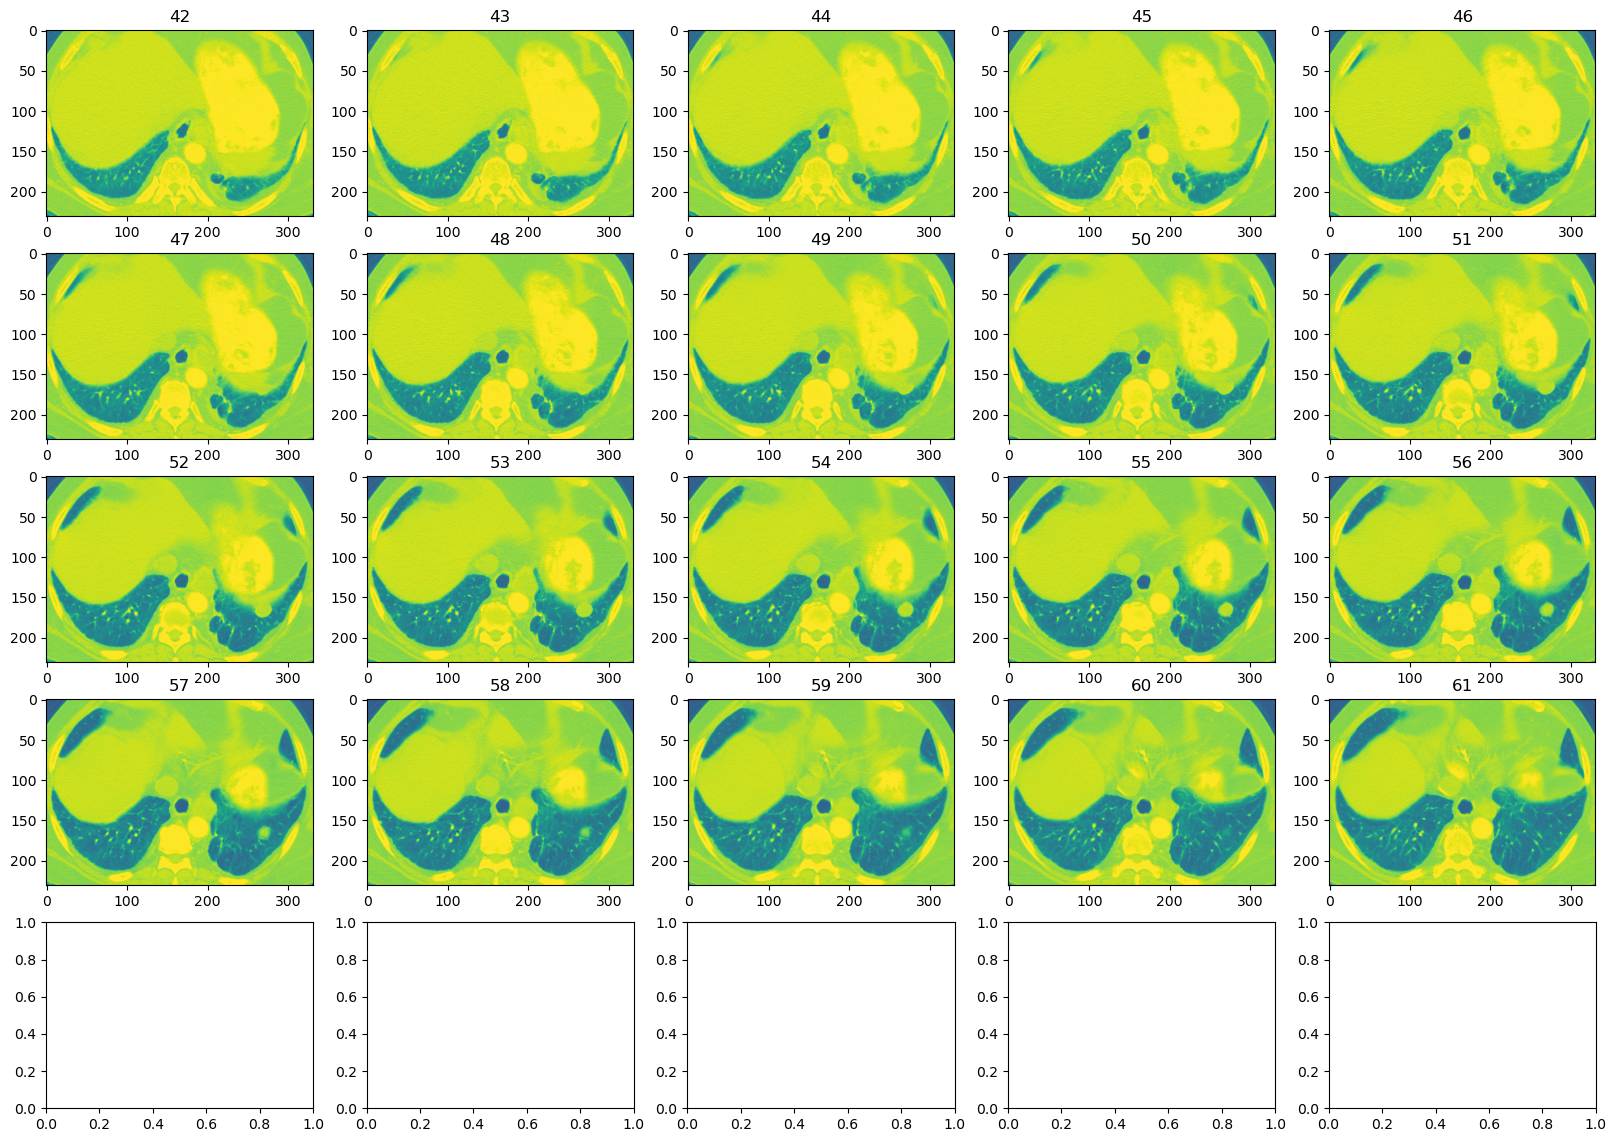

In [ ]:
plot_ct(new_img, list(range(42, 62)))